In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from netam import framework, models
from netam.common import nt_mask_tensor_of, BASES
from netam.framework import SHMoofDataset

from epam import molevol, sequences
from epam.molevol import reshape_for_codons, build_mutation_matrices, codon_probs_of_mutation_matrices

import sys
sys.path.append("/Users/matsen/re/netam-experiments-1")
from shmex.shm_data import load_shmoof_dataframes, pcp_df_of_non_shmoof_nickname, dataset_dict

In [2]:
data_nickname = "shmoof"
pcp_df = pcp_df_of_non_shmoof_nickname(data_nickname)
crepe_path = "../train/trained_models/cnn_joi_lrg-shmoof_small-fixed-0"
crepe = framework.load_crepe(crepe_path)
model = crepe.model
site_count = 500

Loading /Users/matsen/data/shmoof_pcp_2023-11-30_MASKED.csv.gz


In [3]:
train_df, val_df = load_shmoof_dataframes(dataset_dict["shmoof"], val_nickname="small")
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
train_df["branch_length"] = pd.read_csv(crepe_path+".train_branch_lengths.csv")["branch_length"]
pcp_df = train_df

In [4]:
def trim_seqs_to_codon_boundary(seqs):
    return [seq[:len(seq) - len(seq) % 3] for seq in seqs]

pcp_df["parent"] = trim_seqs_to_codon_boundary(pcp_df["parent"])
pcp_df["child"] = trim_seqs_to_codon_boundary(pcp_df["child"])

# take the first 1000 row
# pcp_df = pcp_df[:1000].copy()

In [5]:
def codon_probs_of_parent_scaled_rates_and_sub_probs(parent_idxs, scaled_rates, sub_probs):
    # This is from `aaprobs_of_parent_scaled_rates_and_sub_probs`.
    mut_probs = 1.0 - torch.exp(-scaled_rates)
    parent_codon_idxs = reshape_for_codons(parent_idxs)
    codon_mut_probs = reshape_for_codons(mut_probs)
    codon_sub_probs = reshape_for_codons(sub_probs)
    
    # This is from `aaprob_of_mut_and_sub` 
    mut_matrices = build_mutation_matrices(parent_codon_idxs, codon_mut_probs, codon_sub_probs)
    codon_probs = codon_probs_of_mutation_matrices(mut_matrices)

    return codon_probs

In [6]:
# Function to calculate the number of differences between two codons
def num_differences(codon1, codon2):
    return sum(c1 != c2 for c1, c2 in zip(codon1, codon2))

# Initialize a dictionary to store num_diff_tensors indexed by codons
num_diff_tensors = {}

# Iterate over all possible codons and calculate the num_diff_tensors
for i, base1 in enumerate(BASES):
    for j, base2 in enumerate(BASES):
        for k, base3 in enumerate(BASES):
            codon = base1 + base2 + base3
            num_diff_tensor = torch.zeros(4, 4, 4, dtype=torch.int)
            for i2, base1_2 in enumerate(BASES):
                for j2, base2_2 in enumerate(BASES):
                    for k2, base3_2 in enumerate(BASES):
                        codon_2 = base1_2 + base2_2 + base3_2
                        num_diff = num_differences(codon, codon_2)
                        num_diff_tensor[i2, j2, k2] = num_diff
            num_diff_tensors[codon] = num_diff_tensor

# make a dict mapping from codon to triple integer index
codon_to_idxs = {base_1+base_2+base_3: (i, j, k) for i, base_1 in enumerate(BASES) for j, base_2 in enumerate(BASES) for k, base_3 in enumerate(BASES)}
codon_to_idxs

ctc_num_diff_tensor = num_diff_tensors["CTC"]
assert ctc_num_diff_tensor[codon_to_idxs["CTC"]] == 0
assert ctc_num_diff_tensor[codon_to_idxs["ATC"]] == 1
assert ctc_num_diff_tensor[codon_to_idxs["ACC"]] == 2
assert ctc_num_diff_tensor[codon_to_idxs["ACT"]] == 3

In [7]:
def probs_of_difference_count(num_diff_tensor, codon_probs):
    """
    Calculate total probabilities for each number of differences between codons.

    Args:
    - num_diff_tensor (torch.Tensor): A 4x4x4 integer tensor containing the number of differences
                                       between each codon and a reference codon.
    - codon_probs (torch.Tensor): A 4x4x4 tensor containing the probabilities of various codons.

    Returns:
    - total_probs (torch.Tensor): A 1D tensor containing the total probabilities for each number
                                   of differences (0 to 3).
    """
    total_probs = []

    for differences_count in range(4):
        # Create a mask of codons with the desired number of differences
        mask = num_diff_tensor == differences_count

        # Multiply componentwise with the codon_probs tensor and sum
        total_prob = (codon_probs * mask.float()).sum()

        # Append the total probability to the list
        total_probs.append(total_prob.item())

    return torch.tensor(total_probs)

In [8]:
def probs_of_difference_count_seq(parent_seq, codon_probs, num_diff_tensors):
    """
    Calculate probabilities of difference count between parent codons and all other codons for all the sites of a sequence.

    Args:
    - parent_seq (str): The parent nucleotide sequence.
    - codon_probs (torch.Tensor): A tensor containing the probabilities of various codons.
    - num_diff_tensors (dict): A dictionary containing num_diff_tensors indexed by codons.

    Returns:
    - probs (torch.Tensor): A tensor containing the probabilities of different
                                                 counts of differences between parent codons and
                                                 all other codons.
    """
    # Check if the size of the first dimension of codon_probs matches the length of parent_seq divided by 3
    if len(parent_seq) // 3 != codon_probs.size(0):
        raise ValueError("The size of the first dimension of codon_probs should match the length of parent_seq divided by 3.")

    # Initialize a list to store the probabilities of different counts of differences
    probs = []

    # Iterate through codons in parent_seq
    for i in range(0, len(parent_seq), 3):
        # Extract the codon from parent_seq
        codon = parent_seq[i:i+3]

        # if codon contains an N, append a tensor of 4 -1s to probs then continue
        if "N" in codon:
            probs.append(torch.tensor([-100.0] * 4))
            continue

        # Get the corresponding num_diff_tensor from num_diff_tensors
        num_diff_tensor = num_diff_tensors[codon]

        # Get the ith entry of codon_probs
        codon_probs_i = codon_probs[i // 3]

        # Calculate the probabilities of different counts of differences using the num_diff_tensor and codon_probs_i
        total_probs = probs_of_difference_count(num_diff_tensor, codon_probs_i)

        # Append the probabilities to the list
        probs.append(total_probs)

    # Concatenate all the probabilities into a tensor
    probs = torch.stack(probs)

    return probs


In [9]:
rates, csps = framework.trimmed_shm_model_outputs_of_crepe(crepe, pcp_df["parent"])
pcp_df["rates"] = rates
pcp_df["subs_probs"] = csps

In [10]:
parent, rates, subs_probs, branch_length = pcp_df.loc[0, ["parent", "rates", "subs_probs", "branch_length"]]
# truncate each to be a multiple of 3 in length
parent = parent[:len(parent) - len(parent) % 3]
rates = rates[:len(rates) - len(rates) % 3]
subs_probs = subs_probs[:len(subs_probs) - len(subs_probs) % 3]

mask = nt_mask_tensor_of(parent)
parent_idxs = sequences.nt_idx_tensor_of_str(parent.replace("N", "A"))
parent_len = len(parent)
scaled_rates = branch_length * rates[:parent_len]

codon_probs = codon_probs_of_parent_scaled_rates_and_sub_probs(parent_idxs, scaled_rates, subs_probs)
last_codon_probs = codon_probs[-1]
last_codon_probs

# Example usage:
probs_of_difference_count_seq(parent, codon_probs, num_diff_tensors)[-6:]

tensor([[9.8838e-01, 1.1576e-02, 3.9784e-05, 3.9472e-08],
        [9.8436e-01, 1.5556e-02, 8.0096e-05, 1.3358e-07],
        [9.8991e-01, 1.0065e-02, 2.6426e-05, 1.5379e-08],
        [9.9122e-01, 8.7560e-03, 2.5097e-05, 2.3505e-08],
        [9.9409e-01, 5.8967e-03, 1.1123e-05, 6.6755e-09],
        [9.8765e-01, 1.2329e-02, 2.4462e-05, 1.1690e-08]])

In [11]:
def count_codon_mutations(pcp_df, child_col="child", seed=42):
    # Initialize the random number generator
    rng = np.random.default_rng(seed)
    
    # Dictionary to store total counts of mutations across all PCPs
    mutation_counts = {0: 0, 1: 0, 2: 0, 3: 0}
    
    # Loop over each row in the DataFrame
    for index, row in pcp_df.iterrows():
        parent_seq = row['parent']
        child_seq = row[child_col]
        
        # Select a random frame
        frame = rng.integers(0, 3)
        
        # Process sequences starting from the selected frame
        for i in range(frame, len(parent_seq) - 2, 3):
            parent_codon = parent_seq[i:i+3]
            child_codon = child_seq[i:i+3]
            
            # Ensure we have complete codons
            if len(parent_codon) == 3 and len(child_codon) == 3:
                # Count mutations
                mutations = sum(1 for a, b in zip(parent_codon, child_codon) if a != b)
                mutation_counts[mutations] += 1

    return mutation_counts

child_codon_mut_count = count_codon_mutations(pcp_df, child_col="child")
child_codon_mut_count

{0: 5460296, 1: 147591, 2: 13450, 3: 1922}

In [12]:
mutated_codons_count = sum(child_codon_mut_count[i] for i in range(1, 4))
mutated_codons_count

162963

In [26]:
total_diff_probs = torch.zeros(4)
prob_count = 0

all_diff_probs_l = []

# loop through every row of pcp_df
for _, row in pcp_df.iterrows():
    parent = row['parent']
    rates = row['rates']
    subs_probs = row['subs_probs']
    branch_length = row['branch_length']

    parent = parent[:len(parent) - len(parent) % 3]
    rates = rates[:len(rates) - len(rates) % 3]
    subs_probs = subs_probs[:len(subs_probs) - len(subs_probs) % 3]

    parent_idxs = sequences.nt_idx_tensor_of_str(parent.replace("N", "A"))
    scaled_rates = branch_length * rates

    codon_probs = codon_probs_of_parent_scaled_rates_and_sub_probs(parent_idxs, scaled_rates, subs_probs)

    diff_probs = probs_of_difference_count_seq(parent, codon_probs, num_diff_tensors)
    all_diff_probs_l.append(diff_probs)

    real_diff_probs = diff_probs[diff_probs.min(axis=1).values > torch.tensor([-99.]), :]
    total_diff_probs += real_diff_probs.sum(dim=0)
    prob_count += real_diff_probs.shape[0]

all_diff_probs = torch.cat(all_diff_probs_l)
all_diff_probs.shape
    
mean_diff_probs = total_diff_probs / prob_count
mean_diff_probs

tensor([9.6143e-01, 3.6899e-02, 1.5889e-03, 6.6378e-05])

In [30]:
padded_diff_probs = torch.nn.utils.rnn.pad_sequence(all_diff_probs_l, batch_first=True, padding_value=-100.0)
# pad padded_diff_probs even more to make the second dimension of size site_count//3
padded_diff_probs = F.pad(padded_diff_probs, (0, 0, 0, site_count//3 - padded_diff_probs.size(1)))
padded_diff_probs.shape

torch.Size([46391, 166, 4])

In [31]:
padded_diff_probs[:2, 100:110, :]

tensor([[[9.6100e-01, 3.8496e-02, 5.0613e-04, 2.1828e-06],
         [9.6540e-01, 3.4200e-02, 4.0073e-04, 1.5525e-06],
         [9.7542e-01, 2.4380e-02, 2.0197e-04, 5.5438e-07],
         [9.6415e-01, 3.5444e-02, 4.0254e-04, 1.4548e-06],
         [9.7965e-01, 2.0217e-02, 1.3727e-04, 3.0719e-07],
         [9.7689e-01, 2.2934e-02, 1.7940e-04, 4.6760e-07],
         [9.7721e-01, 2.2617e-02, 1.7148e-04, 4.2397e-07],
         [9.5119e-01, 4.8072e-02, 7.3396e-04, 3.4971e-06],
         [9.8771e-01, 1.2253e-02, 4.1428e-05, 3.4128e-08],
         [9.9568e-01, 4.3153e-03, 6.2082e-06, 2.9648e-09]],

        [[9.2351e-01, 7.4498e-02, 1.9720e-03, 1.7120e-05],
         [9.3199e-01, 6.6430e-02, 1.5659e-03, 1.2204e-05],
         [9.5144e-01, 4.7762e-02, 7.9463e-04, 4.3803e-06],
         [9.2959e-01, 6.8827e-02, 1.5726e-03, 1.1428e-05],
         [9.5971e-01, 3.9750e-02, 5.4167e-04, 2.4324e-06],
         [9.5431e-01, 4.4984e-02, 7.0653e-04, 3.6974e-06],
         [9.5494e-01, 4.4380e-02, 6.7556e-04, 3.3530e-

In [24]:
# compute quartiles of pcp_df["branch_length"]
pcp_quantiles = pcp_df["branch_length"].quantile([0.25, 0.5, 0.75])
# add a quantile column to pcp_df
pcp_df["branch_length_quantile"] = pd.qcut(pcp_df["branch_length"], q=4, labels=False)
pcp_df["branch_length_quantile"].value_counts()

branch_length_quantile
0    11881
3    11566
2    11534
1    11410
Name: count, dtype: int64

In [37]:
def mean_excluding_sentinel(padded_tensor, sentinel_value):
    """
    Calculate the mean across all dimensions of a padded tensor, excluding the last one,
    while excluding a specified sentinel value.

    Args:
    - padded_tensor (torch.Tensor): The padded tensor.
    - sentinel_value (int): The sentinel value to be excluded from the mean calculation.

    Returns:
    - mean_excluding_sentinel (torch.Tensor): The mean across all dimensions, excluding the last one,
                                              while excluding the sentinel value.
    """
    # Mask out the sentinel value and padding
    masked_tensor = torch.where(padded_tensor != sentinel_value, padded_tensor, torch.tensor(0))

    # Calculate the sum and count of non-sentinel values along all dimensions except the last one
    sum_non_sentinel = masked_tensor.sum(dim=tuple(range(masked_tensor.ndim - 1)))
    count_non_sentinel = (masked_tensor != 0).sum(dim=tuple(range(masked_tensor.ndim - 1)))

    # Calculate the mean across all dimensions except the last one, excluding the sentinel value
    mean_excluding_sentinel = sum_non_sentinel / count_non_sentinel

    return mean_excluding_sentinel

# Assertion test
padded_tensor = torch.tensor([[1, 2, -100, -100],
                               [4, -100, -100, -100],
                               [7, 7, 8, 9]])
sentinel_value = -100
expected_mean = torch.tensor([4., 4.5, 8, 9])
assert torch.allclose(mean_excluding_sentinel(padded_tensor, sentinel_value), expected_mean), "Test failed!"


Assertion test passed successfully!


In [44]:
relative_data = []

for quantile in pcp_df["branch_length_quantile"].unique():
    child_codon_mut_count_q = count_codon_mutations(pcp_df[pcp_df["branch_length_quantile"] == quantile], child_col="child")

    # let all_diff_probs_q be the subset of all_diff_probs corresponding when pcp_df["branch_length_quantile"] == quantile
    padded_diff_probs_q = padded_diff_probs[pcp_df["branch_length_quantile"] == quantile]
    predictions = mean_excluding_sentinel(padded_diff_probs_q, -100.0)

    for i in range(2, 4):
        relative_data.append({
            "branch_length_quantile": quantile,
            "mutation_count": i,
            "mutation_count_relative": child_codon_mut_count_q[i] / child_codon_mut_count_q[1],
            "relative_prob": (predictions[i] / predictions[1]).item(),
        })

relative_df = pd.DataFrame(relative_data)
# sort by branch_length_quantile and mutation_count
relative_df = relative_df.sort_values(["branch_length_quantile", "mutation_count"]).reset_index(drop=True)
relative_df


,branch_length_quantile,mutation_count,mutation_count_relative,relative_prob
0,0,2,0.000000,0.004326
1,0,3,0.000000,0.000009
2,1,2,0.015376,0.007141
3,1,3,0.000000,0.000025
4,2,2,0.056794,0.015962
5,2,3,0.005409,0.000130
6,3,2,0.128889,0.062159
7,3,3,0.020101,0.002841


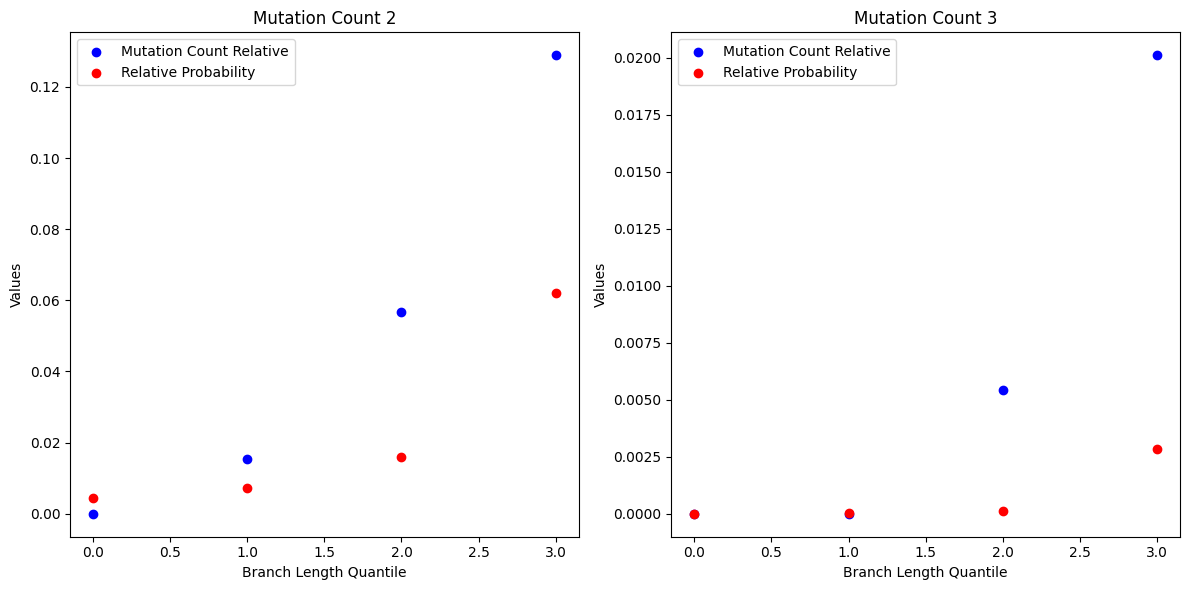

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Filter the data for each mutation count
for i, mutation_count in enumerate(relative_df['mutation_count'].unique()):
    df_filtered = relative_df[relative_df['mutation_count'] == mutation_count]
    
    axes[i].scatter(df_filtered['branch_length_quantile'], df_filtered['mutation_count_relative'], color='blue', label='Mutation Count Relative')
    axes[i].scatter(df_filtered['branch_length_quantile'], df_filtered['relative_prob'], color='red', label='Relative Probability')
    
    axes[i].set_title(f'Mutation Count {mutation_count}')
    axes[i].set_xlabel('Branch Length Quantile')
    axes[i].set_ylabel('Values')
    axes[i].legend()

plt.tight_layout()
plt.show()


In [34]:
import torch

# Example padded tensor with sentinel value and padding
padded_tensor = torch.tensor([[1, 2, -100, -100],
                               [4, -100, -100, -100],
                               [6, 7, 8, 9]])

# Define the sentinel value
sentinel_value = -100

# Mask out the sentinel value and padding
masked_tensor = torch.where(padded_tensor != sentinel_value, padded_tensor, torch.tensor(0))

# Calculate the sum and count of non-sentinel values along all dimensions except the last one
sum_non_sentinel = masked_tensor.sum(dim=tuple(range(masked_tensor.ndim - 1)))
count_non_sentinel = (masked_tensor != 0).sum(dim=tuple(range(masked_tensor.ndim - 1)))

# Calculate the mean across all dimensions except the last one, excluding the sentinel value
mean_excluding_sentinel = sum_non_sentinel / count_non_sentinel

print("Mean excluding sentinel value:", mean_excluding_sentinel)


Mean excluding sentinel value: tensor([3.6667, 4.5000, 8.0000, 9.0000])


In [14]:
relative_data = []

for i in range(2, 4):
    relative_mutation_rate = mean_diff_probs[i] / mean_diff_probs[1]
    relative_mutation_count = child_codon_mut_count[i] / child_codon_mut_count[1]
    relative_data.append((i, relative_mutation_rate.item(), relative_mutation_count))
    
relative_df = pd.DataFrame(relative_data, columns=["num_diff", "relative_mutation_rate", "relative_mutation_count"])
relative_df["ratio"] =  relative_df["relative_mutation_count"] / relative_df["relative_mutation_rate"]
relative_df

,num_diff,relative_mutation_rate,relative_mutation_count,ratio
0,2,0.043062,0.091130,2.116276
1,3,0.001799,0.013022,7.239081


In [18]:
def labels_of_pcp_df(pcp_df, codon_count):
    labels = torch.zeros((len(pcp_df), codon_count), dtype=torch.int64)

    for index, row in pcp_df.iterrows():
        parent_seq = row['parent']
        child_seq = row['child']

        assert len(parent_seq) == len(child_seq)
        valid_length = (len(parent_seq) // 3) * 3
        
        # Check and warn if the valid codon count exceeds the codon_count parameter
        if valid_length // 3 > codon_count:
            print(f"Warning: Truncating sequences at index {index} to {codon_count} codons, though {valid_length // 3} could be processed.")

        # Chunk into codons and count mutations
        num_mutations = []
        for i in range(0, valid_length, 3):
            parent_codon = parent_seq[i:i+3]
            child_codon = child_seq[i:i+3]
            
            if 'N' in parent_codon or 'N' in child_codon:
                num_mutations.append(-1)
            else:
                # Count differing bases
                mutations = sum(1 for p, c in zip(parent_codon, child_codon) if p != c)
                num_mutations.append(mutations)
        
        # Pad or truncate the mutation counts to match codon_count
        padded_mutations = num_mutations[:codon_count]  # Truncate if necessary
        padded_mutations += [-1] * (codon_count - len(padded_mutations))  # Pad with -1s
        
        # Update the labels tensor for this row
        labels[index] = torch.tensor(padded_mutations, dtype=torch.int)

    return labels

# Example usage
data = {
    'parent': ['ATGCGTACGTAG', 'GTCGATCGATCG'],
    'child':  ['ATGCGTAGGTAN', 'GTCGATCGTTGA']
}
example_df = pd.DataFrame(data)
labels_tensor = labels_of_pcp_df(example_df, 4)
print(labels_tensor)


tensor([[ 0,  0,  1, -1],
        [ 0,  0,  1,  2]])


In [ ]:
labels = labels_of_pcp_df(pcp_df, site_count//3)